In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import os
import joblib

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, learning_curve, StratifiedKFold, cross_validate, GridSearchCV
from sklearn.metrics import recall_score, f1_score, precision_score, accuracy_score
from sklearn.feature_selection import SelectFromModel
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer

from yellowbrick.cluster import KElbowVisualizer

import warnings
warnings.filterwarnings("ignore")

In [2]:
# load in the customer credit csv data 
customer_data = pd.read_csv("data/CC GENERAL.csv")
customer_data.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


The head view above indicates that we have only numerical values.

### Using the info of the data to get more description of the dataset columns.

In [3]:
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA

NOTES
* There are 8950 entries in the data and 18 columns in the data.
* There are NULL values in some of the columns in the data.
* We mostly have a float data type in the columns available in the dataset. The only string format column is the CUST_ID which represents each customer ID.
* The customer ID column provides no useful information that can be used in the data.
* There are also no null values in the dataset.

In [4]:
print(f"There are {len(customer_data['CUST_ID'].unique())} unique values in the customer ID column")

There are 8950 unique values in the customer ID column


This indicates that the customer ID column can be dropped from the dataframe since it basically acts like an index.

In [5]:
# drop the customer ID column
customer_data_prepared = customer_data.drop(columns="CUST_ID")

### Handling the NULL columns

In [6]:
# Get the null values in the dataset
number_of_nans = customer_data_prepared.isnull().sum().sum()
print(f"The number total of the NaN values are: {number_of_nans}\n")
print("The columns with null values are:")
for column in customer_data_prepared.columns:
    if customer_data_prepared[column].isnull().sum() > 0:
        print(column)

The number total of the NaN values are: 314

The columns with null values are:
CREDIT_LIMIT
MINIMUM_PAYMENTS


Filling the NULL values with their means

In [7]:
for column in ["CREDIT_LIMIT", "MINIMUM_PAYMENTS"]:
    # Calculate the mean for each class in the numerical column
    column_mean = customer_data_prepared[column].mean()
    # Fill missing values
    customer_data_prepared[column] = customer_data_prepared[column].fillna(column_mean)

In [8]:
customer_data_prepared.isnull().sum()

BALANCE                             0
BALANCE_FREQUENCY                   0
PURCHASES                           0
ONEOFF_PURCHASES                    0
INSTALLMENTS_PURCHASES              0
CASH_ADVANCE                        0
PURCHASES_FREQUENCY                 0
ONEOFF_PURCHASES_FREQUENCY          0
PURCHASES_INSTALLMENTS_FREQUENCY    0
CASH_ADVANCE_FREQUENCY              0
CASH_ADVANCE_TRX                    0
PURCHASES_TRX                       0
CREDIT_LIMIT                        0
PAYMENTS                            0
MINIMUM_PAYMENTS                    0
PRC_FULL_PAYMENT                    0
TENURE                              0
dtype: int64

This indicates that all the NULL values have been filled.

### Observing the summary statistics of the columns

In [9]:
customer_data.describe()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
count,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8949.000000,8950.000000,8637.000000,8950.000000,8950.000000
mean,1564.474828,0.877271,1003.204834,592.437371,411.067645,978.871112,0.490351,0.202458,0.364437,0.135144,3.248827,14.709832,4494.449450,1733.143852,864.206542,0.153715,11.517318
std,2081.531879,0.236904,2136.634782,1659.887917,904.338115,2097.163877,0.401371,0.298336,0.397448,0.200121,6.824647,24.857649,3638.815725,2895.063757,2372.446607,0.292499,1.338331
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,0.000000,0.019163,0.000000,6.000000
25%,128.281915,0.888889,39.635000,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,1.000000,1600.000000,383.276166,169.123707,0.000000,12.000000
50%,873.385231,1.000000,361.280000,38.000000,89.000000,0.000000,0.500000,0.083333,0.166667,0.000000,0.000000,7.000000,3000.000000,856.901546,312.343947,0.000000,12.000000
75%,2054.140036,1.000000,1110.130000,577.405000,468.637500,1113.821139,0.916667,0.300000,0.750000,0.222222,4.000000,17.000000,6500.000000,1901.134317,825.485459,0.142857,12.000000
max,19043.138560,1.000000,49039.570000,40761.250000,22500.000000,47137.211760,1.000000,1.000000,1.000000,1.500000,123.000000,358.000000,30000.000000,50721.483360,76406.207520,1.000000,12.000000


Doing a cursory overview of the description statistics, it can be oberved that the dataset has outliers in some of the columns. Examples include:
* The BALANCE column contain a mean of 1564 but has a huge maximum of 19043 with 75% of it's values being below 2054.14
* The purchases column also has a mean value of 1003.2  but has a maximum value of 49039.57.

Therefore, to confirm other outliers, the interquartile range will be used.

### Observing the TENURE column

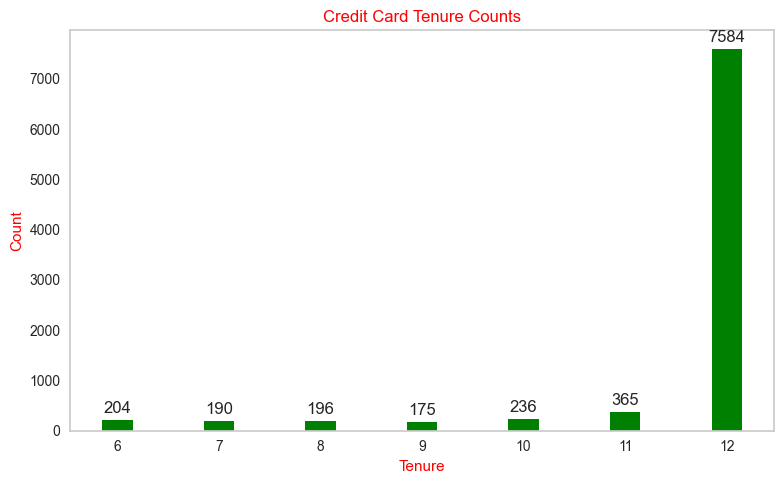

In [10]:
customer_card_tenure_dist = customer_data["TENURE"].value_counts()

# Make a figure for the plot
plt.figure(figsize=(8,5))

# Plot a bar chart for the distribution
bars = plt.bar(
    x=customer_card_tenure_dist.index,
    height=customer_card_tenure_dist.values,
    color="green",
    width=0.3
)

# Loop through the bars and add annotations
for bar in bars:
   height = bar.get_height()
   plt.annotate(text=f'{height}', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3),
   textcoords="offset points", ha='center', va='bottom')

# Label the plot
plt.title("Credit Card Tenure Counts", color="red")
plt.xlabel("Tenure", color="red")
plt.ylabel("Count", color="red")

# Adjust and show the plot with its legend
plt.tight_layout()
plt.grid(visible=False)
plt.show()

It can be observed that the TENURE column in the dataset is not evenly distributed. The dataset mostly contains the data on people that have held on to the card for up to 12(months/years).

In [11]:
# Create a function to determine if a column has outliers or not

def check_outliers(column: pd.Series)->bool:
    """This function accepts a column in a dataframe and uses the describe
    function to get the percentiles used for calculating the interquartile range.
    This is used to determine if there are outliers in the column.

    Args:
        column (pd.Series): The column to be inspected

    Returns:
        bool: True if there are outliers and False otherwise.
    """
    # Get the description of the dataset in a series
    description = column.describe()

    # Get the first and third quartiles
    first_quartile = description["25%"]
    third_quartile = description["75%"]

    # Calculate the interquantile range
    IQR = third_quartile - first_quartile

    # Use this to get the upper and lower fences
    upper_fence = third_quartile + (1.5 * IQR)
    lower_fence = first_quartile - (1.5 * IQR)
    
    # Determine if outliers exist in the series
    if (column > upper_fence).sum() != 0 or (column < lower_fence).sum() != 0:
        return (column > upper_fence).sum() + (column < lower_fence).sum()
    return False

In [12]:
# apply the function to confirm the presence of outliers in columns
customer_data_prepared.apply(check_outliers, axis=0)

BALANCE                               695
BALANCE_FREQUENCY                    1493
PURCHASES                             808
ONEOFF_PURCHASES                     1013
INSTALLMENTS_PURCHASES                867
CASH_ADVANCE                         1030
PURCHASES_FREQUENCY                 False
ONEOFF_PURCHASES_FREQUENCY            782
PURCHASES_INSTALLMENTS_FREQUENCY    False
CASH_ADVANCE_FREQUENCY                525
CASH_ADVANCE_TRX                      804
PURCHASES_TRX                         766
CREDIT_LIMIT                          248
PAYMENTS                              808
MINIMUM_PAYMENTS                      774
PRC_FULL_PAYMENT                     1474
TENURE                               1366
dtype: object

The series above indicates that there are outliers in all of the columns except the PURCHASES_FREQUENCE and PURCHASES_INSTALLMENT_FREQUENCY columns. 

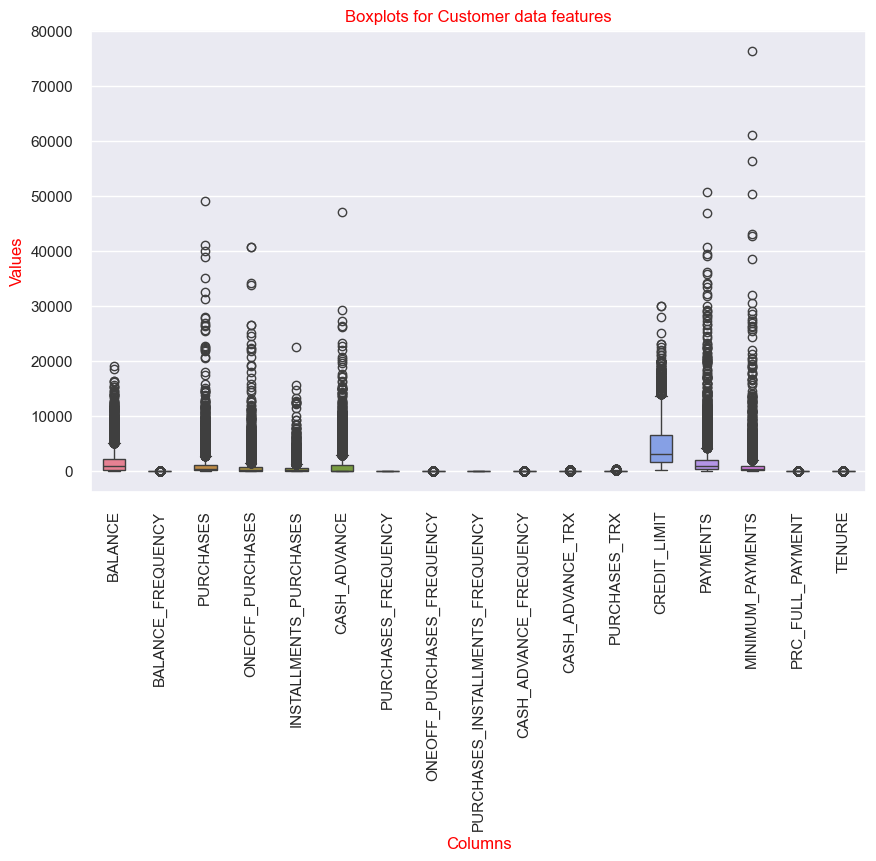

In [13]:
# Set the style for seaborn (optional)
sns.set(style="darkgrid")

# Create multiple boxplots using seaborn
plt.figure(figsize=(10, 6))

sns.boxplot(data=customer_data_prepared, width=0.5)

plt.title('Boxplots for Customer data features', color= "red")
plt.ylabel("Values", color="red")
plt.xlabel("Columns", color="red")
plt.xticks(rotation=90)

plt.show()

NOTES:
* The boxplots above show that most of the columns in the dataset have outliers. 
* However, some of the boxplots are very close to zero because of the very different scales across the columns in the dataset. This proves the varying scales in the data and the need to standardize the data.

### Observing the distribution of the data

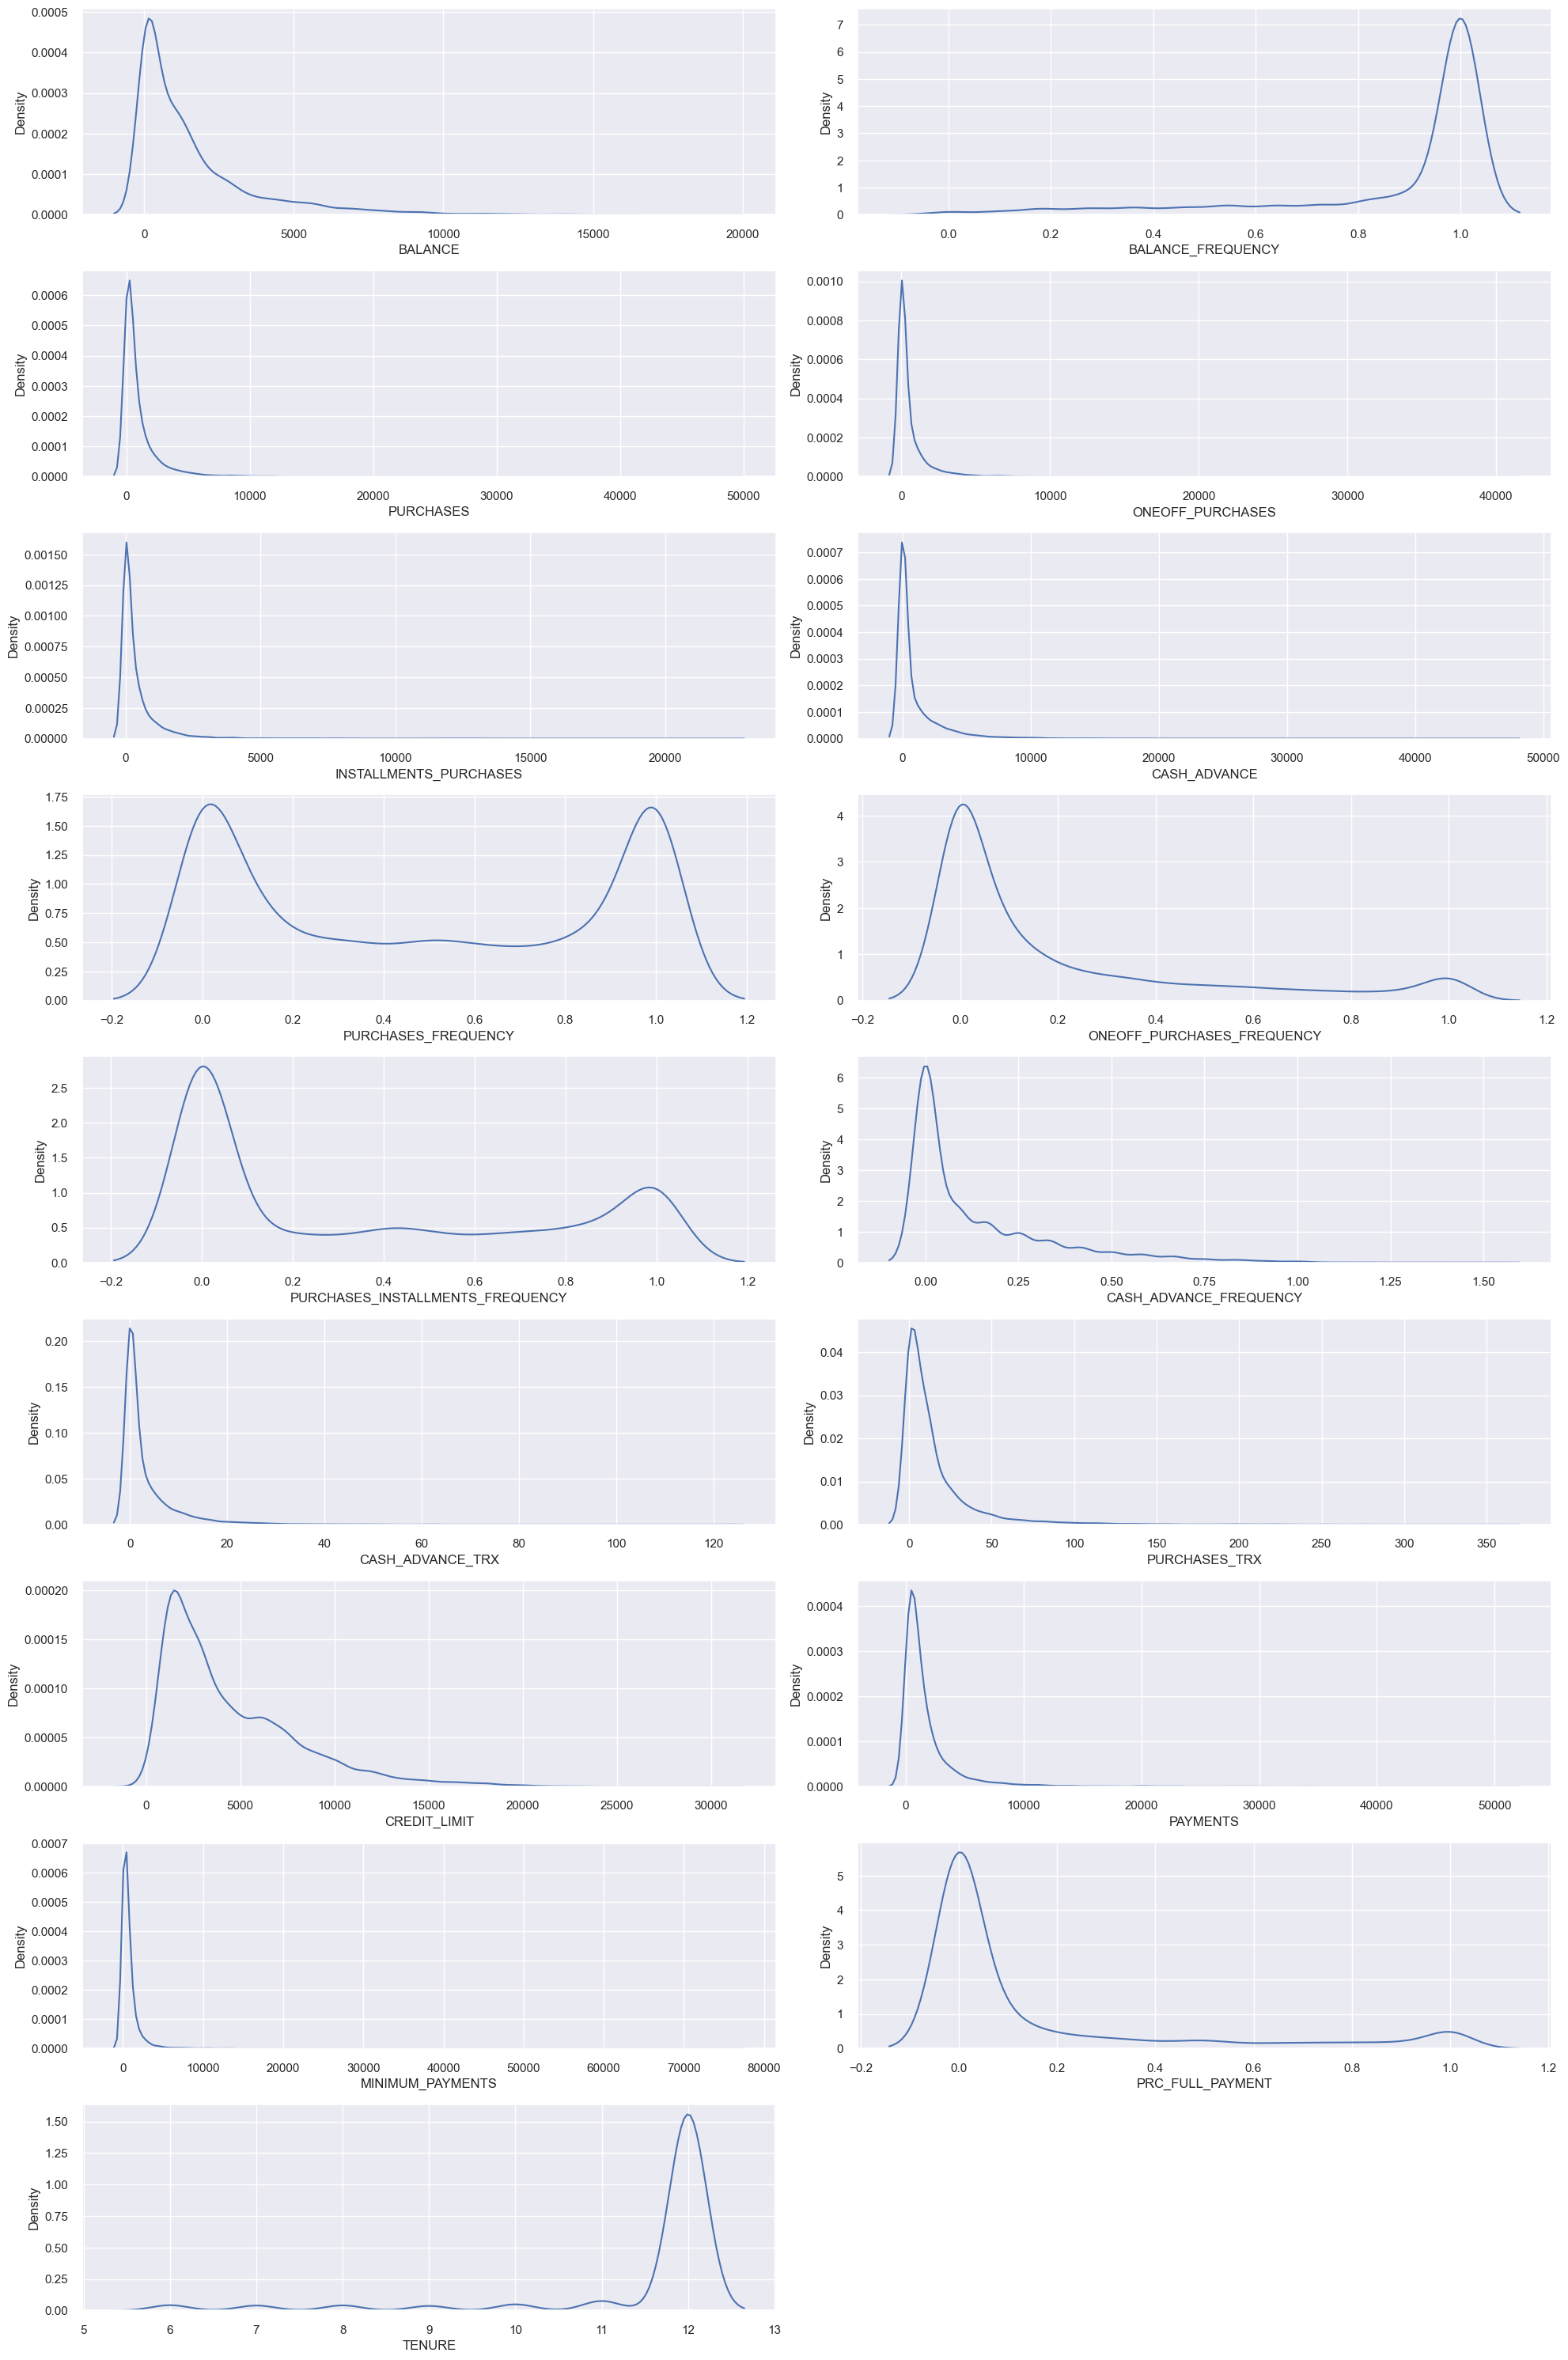

In [14]:
plt.figure(figsize=(20,30))

for i, col in enumerate(customer_data_prepared.columns):
    ax = plt.subplot(9, 2, i+1)
    sns.kdeplot(customer_data_prepared[col], ax=ax)
    plt.xlabel(col)
        
plt.tight_layout()
plt.show()

The plot above shows that most of the columns are skewed and predominantly to the right (positively skewed). To mitigate this, a logarithmic transformation will be applied to this columns. This transformation compresses the range of higher values more than the range of lower values, leading to increased symmetry and reduced skewness. It is particularly effective for positively skewed distributions, where the tail extends towards higher values.

In [15]:
# The list of all positively skewed columns
positively_skewed_cols = [
    'BALANCE', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'ONEOFF_PURCHASES_FREQUENCY',
    'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS', 
    'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT', 'PURCHASES',
]

for col in positively_skewed_cols:
    customer_data_prepared[col] = np.log(1 + customer_data_prepared[col])

### Standardizing the data with a standard scaler

It was also observed that the dataset was not balanced in terms of the scales of the different columns, therefore, the data will be scaled

In [16]:
scaler = StandardScaler()

# scale the entire dataset except the customer ID column
scaled_output = scaler.fit_transform(customer_data_prepared)

customer_data_scaled = pd.DataFrame(data=scaled_output, columns=customer_data_prepared.columns)
customer_data_scaled.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,-1.205218,-0.249434,-0.113532,-0.987090,0.394480,-0.930733,-0.806490,-0.732480,-0.674253,-0.675349,-0.810069,-0.579510,-1.447207,-0.824484,-0.853119,-0.556368,0.36068
1,0.948918,0.134325,-1.679855,-0.987090,-1.087454,1.528788,-1.221758,-0.732480,-0.958256,0.573963,0.784603,-1.379210,0.925998,1.065033,0.870592,0.391958,0.36068
2,0.824993,0.518084,0.600727,1.062022,-1.087454,-0.930733,1.269843,2.466762,-0.958256,-0.675349,-0.810069,0.487865,1.010166,-0.119300,0.416585,-0.556368,0.36068
3,0.624653,-1.016953,0.827499,1.265778,-1.087454,0.564372,-1.014125,-0.363042,-0.958256,-0.258913,-0.123281,-0.874655,1.010166,-4.161996,0.687847,-0.556368,0.36068
4,0.271260,0.518084,-0.708481,-0.114307,-1.087454,-0.930733,-1.014125,-0.363042,-0.958256,-0.675349,-0.810069,-0.874655,-1.224955,-0.064979,-0.379047,-0.556368,0.36068


## Unsupervised Model Creation and Evaluation

Create a function for plotting the number of clusters with the performance on some selected metric

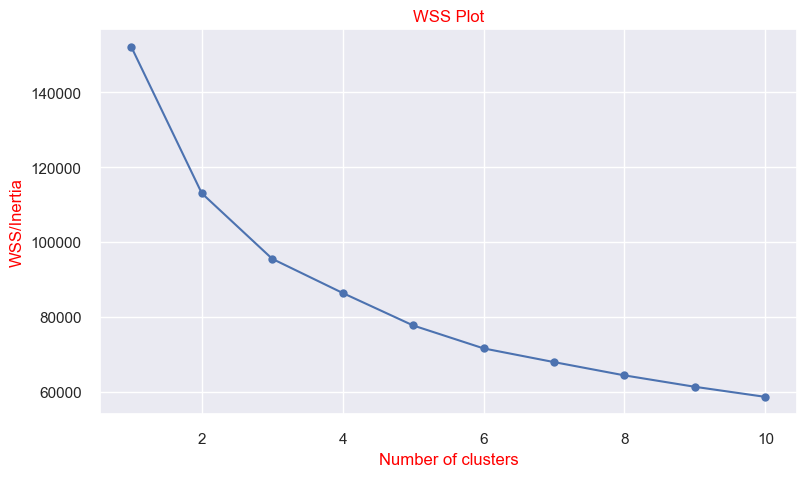

In [17]:
# dictionary for the within sum of squares scores
wss = {}

# using k values in the range of 1 to 10
for k in range(1,11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(customer_data_scaled)
    wss[k] = kmeans.inertia_

#WSS plot
plt.figure(figsize=(9,5))

plt.plot(list(wss.keys()), list(wss.values()), marker='o')

plt.title("WSS Plot", color="red")
plt.xlabel("Number of clusters", color="red")
plt.ylabel("WSS/Inertia", color="red")

plt.show()

In [18]:
def plotElbow(data: pd.DataFrame, metric:str)->None:
    """Make a plot of the clustering performance of a provided dataset using
    a provided metric.
    Metrics include:
        #distortion: mean sum of squared distances to centers
        #silhouette: mean ratio of intra-cluster and nearest-cluster distance
        #calinski_harabasz: ratio of within to between cluster dispersion

    Args:
        data (pd.DataFrame): The data to be clustered
        metric (str): The selected metric
    """
    model = KMeans(random_state=42)
    visualizer = KElbowVisualizer(model, k=(2,15), metric=metric, timings=False) #timing=False ensures training time is not displayed.

    visualizer.fit(data)
    
    plt.figure(figsize=(9,4))
    sns.set(style="darkgrid")

    visualizer.show()

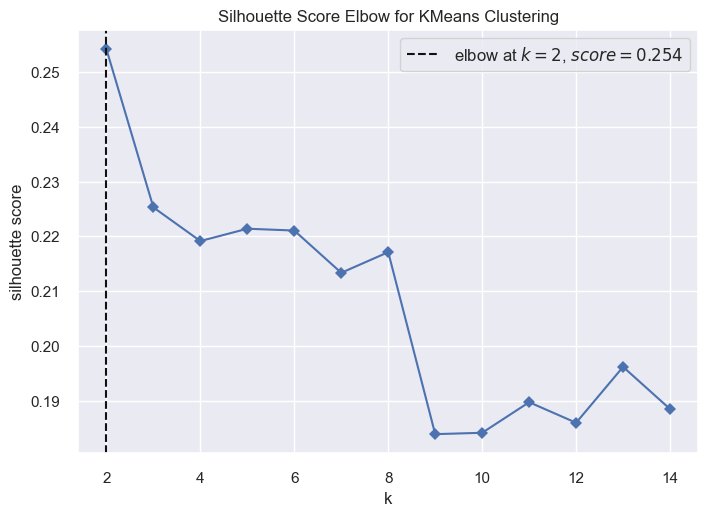

<Figure size 900x400 with 0 Axes>

In [19]:
plotElbow(data=customer_data_scaled, metric="silhouette")

The Silhouette score and the Within Sum of Squares plots above show that the optimal number of clusters that gives optimal value is **2**.

Create the clusters using the discovered optimal number of clusters

In [20]:
#Perform clustering using k-Means
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10, max_iter=300)

cluster_labels = kmeans.fit_predict(customer_data_prepared)

customer_data_scaled["clusters"] = cluster_labels #and assign cluster labels
customer_data_scaled.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,clusters
0,-1.205218,-0.249434,-0.113532,-0.987090,0.394480,-0.930733,-0.806490,-0.732480,-0.674253,-0.675349,-0.810069,-0.579510,-1.447207,-0.824484,-0.853119,-0.556368,0.36068,0
1,0.948918,0.134325,-1.679855,-0.987090,-1.087454,1.528788,-1.221758,-0.732480,-0.958256,0.573963,0.784603,-1.379210,0.925998,1.065033,0.870592,0.391958,0.36068,1
2,0.824993,0.518084,0.600727,1.062022,-1.087454,-0.930733,1.269843,2.466762,-0.958256,-0.675349,-0.810069,0.487865,1.010166,-0.119300,0.416585,-0.556368,0.36068,0
3,0.624653,-1.016953,0.827499,1.265778,-1.087454,0.564372,-1.014125,-0.363042,-0.958256,-0.258913,-0.123281,-0.874655,1.010166,-4.161996,0.687847,-0.556368,0.36068,0
4,0.271260,0.518084,-0.708481,-0.114307,-1.087454,-0.930733,-1.014125,-0.363042,-0.958256,-0.675349,-0.810069,-0.874655,-1.224955,-0.064979,-0.379047,-0.556368,0.36068,0


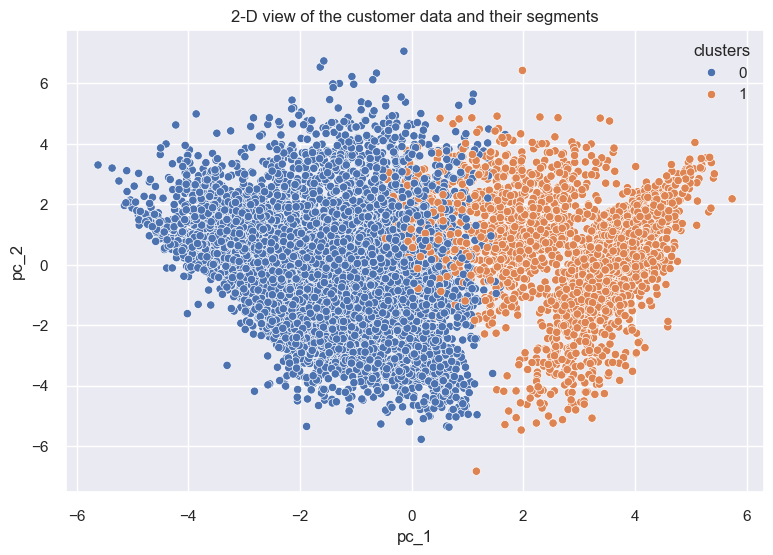

In [21]:
# using PCA to reduce the dimensionality---for purposes of 2D visualization
pca = PCA(n_components=2, whiten=False, random_state=42)

customer_data_pca = pca.fit_transform(customer_data_scaled)
customer_data_pca = pd.DataFrame(data=customer_data_pca, columns=["pc_1", "pc_2"])

customer_data_pca["clusters"] = cluster_labels

# plotting the clusters with seaborn
plt.figure(figsize=(9,6))

sns.scatterplot(x="pc_1", y="pc_2", hue="clusters", data=customer_data_pca)
plt.title("2-D view of the customer data and their segments")

plt.show()

The principal components plot with the cluster labels indicate that there are two major customer segements in the data.

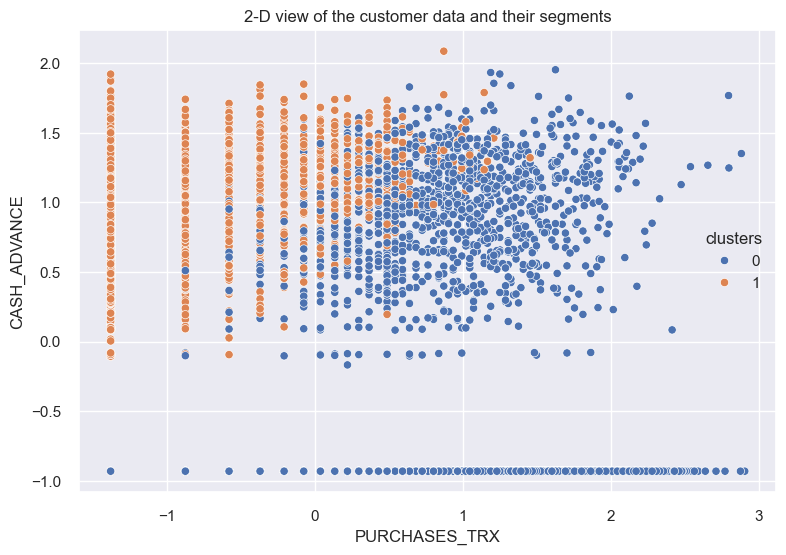

In [94]:
# plotting the clusters with seaborn
plt.figure(figsize=(9,6))

sns.scatterplot(x="PURCHASES_TRX", y="CASH_ADVANCE", hue="clusters", data=customer_data_scaled)
plt.title("2-D view of the customer data and their segments")

plt.show()

The plot above indicates that the customers labelled 0 make more purchases and are not making a lot of CASH ADVANCES while the other label barely make transactions but are always taking advances. This could indicate financial strain. Therefore, this conclusion has been made on the classes:

LABEL 0: LOW RISK CUSTOMERS \
LABEL 1: HIGH RISK CUSTOMERS

### Creating a dataframe with the labels and saving it as a csv file

In [22]:
# Create a dataframe of the original data with the labels
customer_data["LABELS"] = cluster_labels
customer_data.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,LABELS
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12,0
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12,1
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12,0
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12,0
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12,0


save the dataframe

In [23]:
customer_data.to_csv("data/dowolabi-cc-labeled.csv", index=False)

## Supervised Model Creation and Evaluation

Load the labelled data

In [24]:
credit_card_data_labelled = pd.read_csv("dowolabi-cc-labeled.csv")
credit_card_data_labelled.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,LABELS
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12,0
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12,1
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12,0
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12,0
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12,0


Check the value counts of the labelled column

In [25]:
credit_card_data_labelled["LABELS"].value_counts()

LABELS
0    5933
1    3017
Name: count, dtype: int64

Split the dataset into training and test splits

In [26]:
X = credit_card_data_labelled.drop(columns=["CUST_ID", "LABELS"])
y = credit_card_data_labelled["LABELS"]

X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y, 
                                        test_size=0.3,
                                        shuffle=True,
                                        random_state=42,
                                        stratify=y
                                    )

In [27]:
# Create a SimpleImputer with mean strategy
imputer = SimpleImputer(strategy='mean')

# Fit and transform the data
X_train_imputed = imputer.fit_transform(X_train)

Scale the dataset

In [28]:
customer_cc_scaler = StandardScaler()

X_train_scaled = customer_cc_scaler.fit_transform(X_train_imputed)

Creating a baseline classification model

In [29]:
support_vector_classifier = SVC(random_state=42)

#learning_curve uses stratified k-fold cross validation
train_sizes, train_scores, test_scores = learning_curve(
                                            estimator=support_vector_classifier, 
                                            X=X_train_scaled, 
                                            y=y_train,
                                            train_sizes=np.linspace(0.1,1.0,10),
                                            cv=10,
                                            n_jobs=1,
                                            scoring="f1"
                                        )

train_mean = np.mean(train_scores,axis=1)
train_std = np.std(train_scores,axis=1) #used to indicate the variance of estimate.

test_mean = np.mean(test_scores,axis=1)
test_std = np.std(test_scores,axis=1)

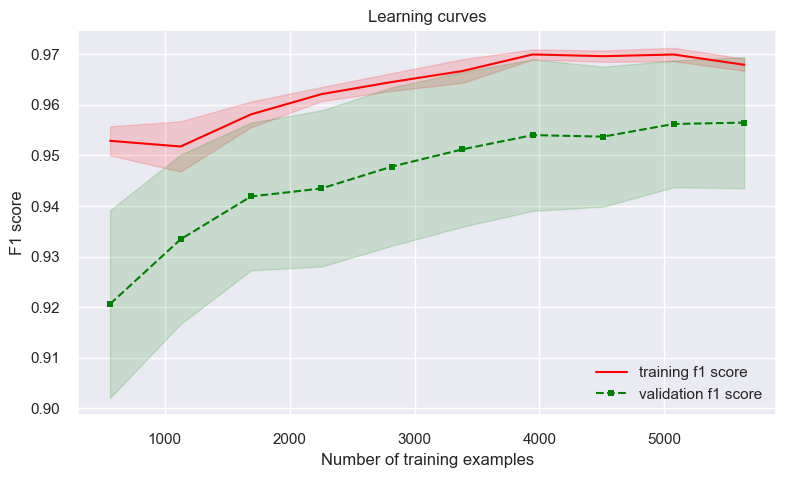

In [30]:
plt.figure(figsize=(9,5))

plt.plot(train_sizes, train_mean, color='red', marker='+', markersize=5, label='training f1 score')
plt.fill_between(train_sizes, train_mean+train_std, train_mean-train_std, alpha=0.15, color='red')

plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation f1 score')
plt.fill_between(train_sizes, test_mean+test_std, test_mean-test_std, alpha=0.15, color='green')

# plt.scatter(best_train_size, test_mean[best_index], c='red', marker='o', label='Best point')

plt.grid(visible=True)
plt.xlabel('Number of training examples')
plt.ylabel('F1 score')
plt.title("Learning curves")
plt.legend(loc='lower right')
# plt.ylim([0.9,1.0])
plt.show()

Training and saving the model

In [52]:
# Training the model
support_vector_classifier = SVC(random_state=42)
support_vector_classifier.fit(X=X_train_scaled, y=y_train)

SVC(random_state=42)

create a function for evaluating model performance

In [53]:
# Create a function for evaluating the cross validation performance of the models
def evaluate_model_performance(fold_scores, model_name):

    # Get the performance of the model's predictions
    average_accuracy = np.mean(fold_scores["test_accuracy"])
    average_precision = np.mean(fold_scores["test_precision_weighted"])
    average_recall = np.mean(fold_scores["test_recall_weighted"])
    average_f_1 = np.mean(fold_scores["test_f1_weighted"])
    
    print(f"The mean cross validation performances of {model_name} model")
    print(f"Average accuracy: {average_accuracy}")
    print(f"Average precision: {average_precision}")
    print(f"Average recall: {average_recall}")
    print(f"Average f1 score {average_f_1}")
    
    return average_precision, average_recall, average_f_1, average_accuracy

In [54]:
# divide the dataset into a number of folds
kfolds = StratifiedKFold(n_splits=10, shuffle=True, random_state=42) # for 10-fold cross validation

In [55]:
svc_fold_scores = cross_validate(
    estimator=support_vector_classifier,
    X=X_train_scaled, 
    y=y_train, 
    cv=kfolds, 
    scoring=['accuracy','precision_weighted','recall_weighted','f1_weighted']
)

svc_precision, svc_recall, svc_f1, svc_accuracy = evaluate_model_performance(svc_fold_scores, "SVC all features")

The mean cross validation performances of SVC all features model
Average accuracy: 0.9703135270648303
Average precision: 0.9702684745101415
Average recall: 0.9703135270648303
Average f1 score 0.9702466696924568


Saving the model

In [104]:
# Create a function for saving the models
def save_estimator(save_name: str, model):

    base_directory = "model_deployment/models"
    file_extension = ".joblib"

    # Create the directory for saving models
    if not os.path.exists(path=base_directory):
        os.mkdir(path=base_directory)

    # save the random_forest model
    joblib.dump(model, os.path.join(base_directory, f"{save_name}{file_extension}"))
    print("The model has been saved successfully")

In [57]:
save_estimator("SVC_all_features", support_vector_classifier)

The model has been saved successfully


**EVALUATION METRIC USED**
* F1 score was used to check the performance of the model because there was a slight imbalance in the labels generated by the clustering model.
* Other metrics like accuracy, precision, and recall were used just to see the performance of the model with them.

**TRAINING CURVE** \
The training curve shows that the model started overfitting the data after about 5200 samples because the training curve started decresing and the validation performance was also relatively constant.

**ALGORITHM USED**
* The Support Vector Machine (Classifier) algorithm was used it works well in high-dimensional spaces, making it suitable for problems with many features like this one. SVCs can also handle non-linear decision boundaries through the use of different kernel functions, allowing them to capture complex relationships in the data. SVMs are also less prone to overfitting, especially in high-dimensional spaces, compared to some other complex models. The margin concept helps in generalization.
* In addition SVCs offer tuning parameters (e.g., regularization parameter C, kernel parameters) that can be adjusted to optimize performance based on cross-validation.
* Lastly, SVMs are memory efficient, particularly in scenarios with a large number of features.

### Feature selection

Create a function for performing the feature selection

In [58]:
def random_forest_feature_selector(X_train, y_train, data_columns):
    # Fit the random forest model selector
    random_forest_model = RandomForestClassifier(random_state=42)
    random_forest_model = random_forest_model.fit(X_train, y_train)

    # Create the feature selector
    selector = SelectFromModel(random_forest_model, prefit=True)
    X_selected_features = selector.transform(X_train)

    print(f"The number of selected features are: {X_selected_features.shape[1]}")

    # Get the boolean mask of selected features
    selected_features_mask = selector.get_support()

    selected_feature_names = np.array(data_columns)[selected_features_mask]

    return selected_feature_names

In [59]:
random_forest_feature_selector(X_train=X_train_scaled, y_train=y_train, data_columns=X_train.columns)

The number of selected features are: 6


array(['PURCHASES', 'CASH_ADVANCE', 'PURCHASES_FREQUENCY',
       'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX'],
      dtype=object)

Therefore the selected features are: \
['PURCHASES', 'CASH_ADVANCE', 'PURCHASES_FREQUENCY', 'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX']

**FEATURE SELECTION**
* The Random forest selection method was used becuase a random forest algorithms are capable of capturing the linearities and non-liniear relationships in the data. With this, it is also able to determine which features were most important to reduce the entropy/impurities in the data which determines it's selected features. 

* The SelectFromModel library was used with this to select the most important features. The default threshold set to the mean importance of the features was used to select the top features.

#### Training the Support Vector Classifier on the selected features only

Create a dataframe from the scaled data

In [98]:
selected_features = ['PURCHASES', 'CASH_ADVANCE', 'PURCHASES_FREQUENCY', 'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX']

X_train_imputed_df = pd.DataFrame(
                        data=X_train_imputed, 
                        columns=X_train.columns
                    )[selected_features]

In [121]:
input_scaler = StandardScaler()
X_train_scaled_selected_features = input_scaler.fit_transform(X_train_imputed_df)

# save the scaler
save_estimator(save_name="cc_standard_scaler", model=input_scaler)

The model has been saved successfully


In [102]:
support_vector_classifier2 = SVC(random_state=42)
# fit the model
support_vector_classifier2.fit(X=X_train_scaled_selected_features, y=y_train)

svc_fold_scores2 = cross_validate(
    estimator=support_vector_classifier2,
    X=X_train_scaled_selected_features, 
    y=y_train, 
    cv=kfolds, 
    scoring=['accuracy','precision_weighted','recall_weighted','f1_weighted']
)

svc2_precision, svc2_recall, svc2_f1, svc2_accuracy = evaluate_model_performance(svc_fold_scores2, "SVC selected features")

The mean cross validation performances of SVC selected features model
Average accuracy: 0.9656834869631238
Average precision: 0.9657446530927594
Average recall: 0.9656834869631238
Average f1 score 0.9656133665597577


saving the model

In [105]:
save_estimator(save_name="SVC_selected_features", model=support_vector_classifier2)

The model has been saved successfully


Comparing the results of the model when all the features were used and when a subset of features were used

In [106]:
#Retrieve precision, recall, and f1-score
svc_model1_scores = {"precision": svc_precision, "recall": svc_recall, "f1score": svc_f1, "accuracy": svc_accuracy}
svc_model2_scores = {"precision": svc2_precision, "recall": svc2_recall, "f1score": svc2_f1, "accuracy": svc2_accuracy}

In [107]:
def plot_model_performance_comparison(
      model_1_scores: dict, 
      model_1_name: str,
      model_2_scores: dict, 
      model_2_name: str,
      additional_title: str = ""
):
   # Save the columns of the 
   metrics = model_1_scores.keys()

   # Create an array of equally spaced x-values for the categories
   x = np.arange(len(metrics))

   # Define the width of the bars
   bar_width = 0.2

   # Make a figure for the plot
   plt.figure(figsize=(8,5))

   # Create the grouped bar plot
   bar_1 = plt.bar(x, model_1_scores.values(), bar_width, label=model_1_name, align='center')
   bar_2 = plt.bar(x - bar_width, model_2_scores.values(), bar_width, label=model_2_name, align='center')

   # Loop through the bars and add annotations
   plots = [bar_1, bar_2]
   for bars in plots:
      for bar in bars:
         height = bar.get_height()
         plt.annotate(text=f'{height:.3f}', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3),
         textcoords="offset points", ha='center', va='bottom', fontsize="8")

   # Customize the plot
   plt.xlabel('Metric', color="red")
   plt.ylabel('Model Performance', color="red")
   plt.title(f'Model metrics comparison {additional_title}', color="red")
   plt.xticks(x, metrics)
   plt.legend(loc="upper right", bbox_to_anchor=(1.34, 1.01))

   # Show the plot
   plt.grid(visible=False)
   plt.ylim(0.8, 1.1)
   plt.show()

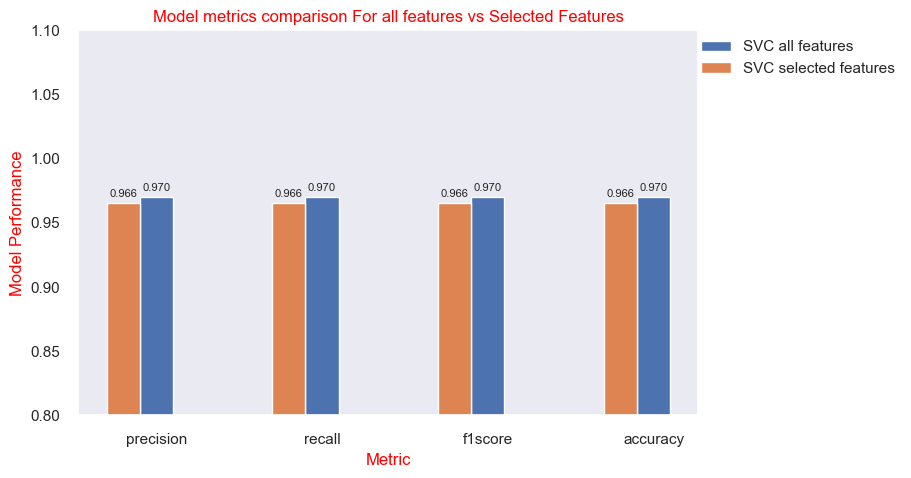

In [108]:
plot_model_performance_comparison(
    model_1_scores=svc_model1_scores, 
    model_1_name='SVC all features',
    model_2_scores=svc_model2_scores,
    model_2_name='SVC selected features',
    additional_title="For all features vs Selected Features"
)

The graph above indicates that the difference in the performances of the two models is not very significant. When just 6 features were used, the model still achieved a very reasonable performance on all the metrics observed.

Therefore: The Benchmark model is the model that was trained on the selected features

### Hyperparameter Tuning

The benchmark model that would be selected is the SVC model with the selected features since the difference between this model and all the features is not a lot.

Using GridSearchCV

In [109]:
grid_kfolds = StratifiedKFold(n_splits=10, shuffle=True, random_state=42) # for 5-fold cross validation

svm_param_grid = {
    'C': [0.1, 1, 10, 100, 150, 200],  # Regularization parameter
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],  # Kernel coefficient for 'rbf'
}

svm_model = SVC(random_state=42)

#Create a GridSearch object
gd_search_svm = GridSearchCV(
                estimator=svm_model,
                param_grid=svm_param_grid,
                cv=grid_kfolds, 
                n_jobs=-1,
                verbose=1,
                scoring='f1',
            )

gd_search_svm = gd_search_svm.fit(X_train_scaled_selected_features, y_train)

Fitting 10 folds for each of 36 candidates, totalling 360 fits


In [110]:
gd_search_svm.best_params_

{'C': 150, 'gamma': 0.1}

Using the performance of the models on the test set to compare their performances

In [114]:
# check the performance of the model on the test set
X_test_selected_features = X_test[selected_features]

imputer_selected = SimpleImputer(strategy="mean")
imputer_selected.fit(X_train[selected_features])
X_test_filled = imputer_selected.transform(X_test_selected_features)

X_test_scaled = input_scaler.transform(X_test_filled)

X_test_scaled_selected_features = pd.DataFrame(
                                    data=X_test_scaled, 
                                    columns=selected_features
                                )

Get the performance of the SVM model that was not tuned

In [115]:
svc_not_tuned_predictions = support_vector_classifier2.predict(X_test_scaled_selected_features)

# Get the performance of the model's predictions
svc_not_tuned_precision = precision_score(y_true=y_test, y_pred=svc_not_tuned_predictions, average="weighted")
svc_not_tuned_recall = recall_score(y_true=y_test, y_pred=svc_not_tuned_predictions, average="weighted")
svc_not_tuned_f_1 = f1_score(y_true=y_test, y_pred=svc_not_tuned_predictions, average="weighted")
svc_not_tuned_accuracy = accuracy_score(y_test, svc_not_tuned_predictions)

print(f"The Test set performances of SVC model benchmark model")
print(f"Accuracy: {svc_not_tuned_accuracy}")
print(f"Precision: {svc_not_tuned_precision}")
print(f"Recall: {svc_not_tuned_recall}")
print(f"F1 score {svc_not_tuned_f_1}")

svc_not_tuned_scores = {"precision": svc_not_tuned_precision, "recall": svc_not_tuned_recall, "f1score": svc_not_tuned_f_1, "accuracy": svc_not_tuned_accuracy}

The Test set performances of SVC model benchmark model
Accuracy: 0.9687150837988827
Precision: 0.9687051396524026
Recall: 0.9687150837988827
F1 score 0.9685913692876691


Get the performance of the tuned SVM model

In [116]:
svc_tuned_predictions = gd_search_svm.best_estimator_.predict(X_test_scaled_selected_features)

# Get the performance of the model's predictions
svc_tuned_precision = precision_score(y_true=y_test, y_pred=svc_tuned_predictions, average="weighted")
svc_tuned_recall = recall_score(y_true=y_test, y_pred=svc_tuned_predictions, average="weighted")
svc_tuned_f_1 = f1_score(y_true=y_test, y_pred=svc_tuned_predictions, average="weighted")
svc_tuned_accuracy = accuracy_score(y_test, svc_tuned_predictions)

print(f"The Test set performances of Hyperparameter tuned SVC model")
print(f"Accuracy: {svc_tuned_accuracy}")
print(f"Precision: {svc_tuned_precision}")
print(f"Recall: {svc_tuned_recall}")
print(f"F1 score {svc_tuned_f_1}")

svc_tuned_scores = {"precision": svc_tuned_precision, "recall": svc_tuned_recall, "f1score": svc_tuned_f_1, "accuracy": svc_tuned_accuracy}

The Test set performances of Hyperparameter tuned SVC model
Accuracy: 0.9705772811918063
Precision: 0.9705253712036432
Recall: 0.9705772811918063
F1 score 0.9705077151413691


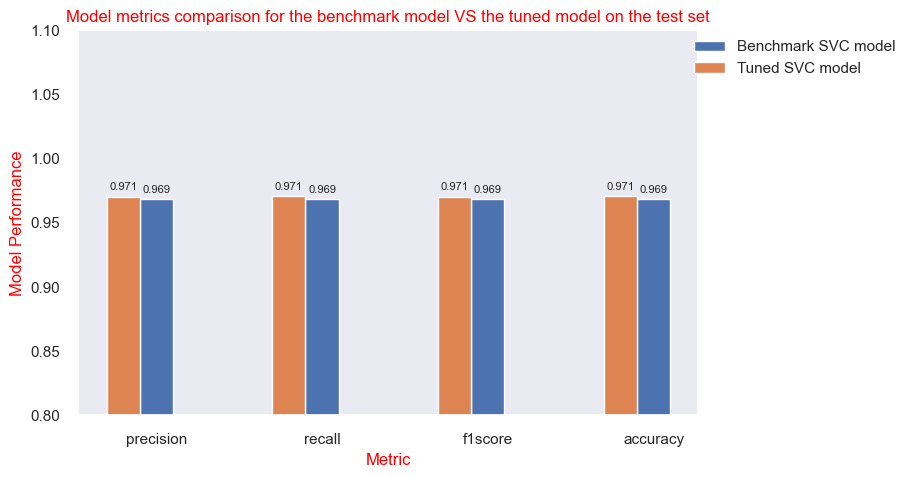

In [117]:
plot_model_performance_comparison(
    model_1_scores=svc_not_tuned_scores, 
    model_1_name="Benchmark SVC model",
    model_2_scores=svc_tuned_scores,
    model_2_name="Tuned SVC model",
    additional_title="for the benchmark model VS the tuned model on the test set"
)

Therefore, the tuned model seems to be better than the benchmark SVC model.

Saving the model

In [118]:
save_estimator(save_name="SVC_tuned", model=gd_search_svm.best_estimator_)

The model has been saved successfully
